# Load data

In [1]:
from input.data_read_write import DataReaderAndWriter
data_holder = DataReaderAndWriter()
data_holder.parse_from_pickle_file("first_dataset.pkl")
data = data_holder.data

# Vocab

## Create from data


from io import BytesIO
from tokenize import tokenize
from collections import Counter
from tqdm.autonotebook import tqdm
max_vocab_size = 1000


c = Counter()

for d in tqdm(data):
    src_code = d['src']
    tokens= tokenize(BytesIO(src_code.encode('utf-8')).readline)
    for _, tokval, _, _, _ in tokens:
        c.update([tokval.lower()])

vocab_dict= {}
for i, vocab in enumerate(c.most_common(max_vocab_size)):
    vocab_dict[vocab[0]] = i

vocab_holder = DataReaderAndWriter()
vocab_holder.data = vocab_dict
vocab_holder.dump_to_file(f"vocab_{max_vocab_size}.pkl")

## Load Vocab

In [2]:
from input.data_read_write import DataReaderAndWriter
vocab = vocab_holder = DataReaderAndWriter()
vocab_holder.parse_from_pickle_file("vocab_1000.pkl")
vocab = vocab_holder.data 

# Random Forest first try

In [3]:
window_size = 20
step_size = 3
problem_type = "RETURN_NULL"
random_state = 1
n_trees_in_forest = 100

In [23]:
import os
folder_name = "1_forest_20_3_100_RETURN_NULL"
target_path = os.path.join("artifacts", folder_name)
os.makedirs(target_path)

## Prepare Data for Random Forest

In [ ]:

from models.random_forst import process_general_data
from sklearn.model_selection import train_test_split
from input.data_read_write import DataReaderAndWriter

x, y = process_general_data(data, vocab)

data_writer = DataReaderAndWriter()
data_writer.data = (x,y)
data_writer.dump_to_file(os.path.join(target_path, "x_y.pkl"))


X_train, X_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=1)
print(f"Length Train: {len(X_train)}, length Test {len(X_test)}")

In [17]:
from input.data_read_write import DataReaderAndWriter

data_writer = DataReaderAndWriter()
data_writer.parse_from_pickle_file(os.path.join(target_path, "x_y.pkl"))
x, y = data_writer.data

X_train, X_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=1)
print(f"Length Train: {len(X_train)}, length Test {len(X_test)}")

In [18]:
from collections import Counter

train_counter = Counter(y_train)
test_counter = Counter(y_test)
print(train_counter)
print(f"Feature Distribution: Train: {train_counter[1] *100/ len(y_train)}%, Test: {test_counter[1] *100/ len(y_test)}%")
# heavily unbalanced

Counter({0: 2126465, 1: 2743})
Feature Distribution: Train: 0.12882724468440848%, Test: 0.12765309918054038%


## Train

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=n_trees_in_forest, 
                            random_state=random_state, 
                            max_features = 'sqrt',
                            n_jobs=-1, verbose = True)

model.fit(X_train, y_train)

from joblib import dump
dump(model, os.path.join(target_path, f"random_forst_{n_trees_in_forest}.joblib"))

In [8]:
from joblib import load
model  = load(os.path.join(target_path, f"random_forst_{n_trees_in_forest}.joblib"))

In [9]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.2s finished


Average number of nodes 9236
Average maximum depth 27
Test Accuracy 0.9987882818400081
Recall Baseline: 1.0 Test: 0.11 Train: 0.98
Precision Baseline: 0.0 Test: 0.66 Train: 1.0
Roc Baseline: 0.5 Test: 0.97 Train: 1.0


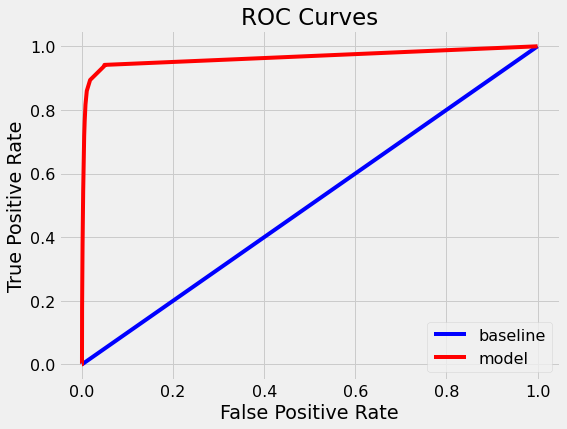

In [10]:
from utils.plotter import evaluate_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')



# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18


evaluate_model(rf_predictions, rf_probs, y_test,  train_rf_predictions, train_rf_probs, y_train)

Normalized confusion matrix
[[9.99929461e-01 7.05387752e-05]
 [8.94039735e-01 1.05960265e-01]]


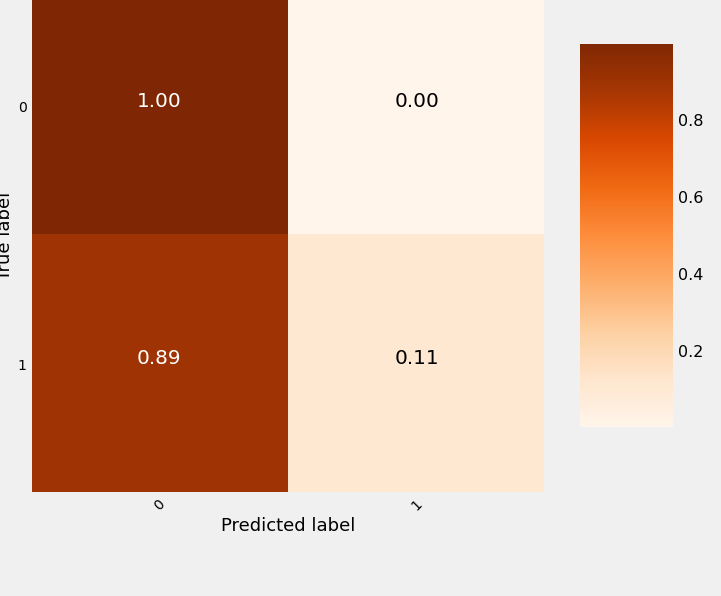

In [12]:
from utils.plotter import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


# Confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix', normalize=True)

# Random Forest with balanced data labels

In [3]:
window_size = 20
step_size = 3
problem_type = "RETURN_NULL"
random_state = 1
n_trees_in_forest = 100

In [4]:
import os
folder_name = "1_forest_20_3_100_RETURN_NULL_balanced_clases"
target_path = os.path.join("artifacts", folder_name)
os.makedirs(target_path)

FileExistsError: [Errno 17] File exists: 'artifacts/1_forest_20_3_100_RETURN_NULL_balanced_clases'


from models.random_forst import process_general_data
from sklearn.model_selection import train_test_split
from input.data_read_write import DataReaderAndWriter
from imblearn.over_sampling import RandomOverSampler

x, y = process_general_data(data, vocab)

#oversample
oversample = RandomOverSampler(sampling_strategy=0.5)
x, y = oversample.fit_resample(x, y)



data_writer = DataReaderAndWriter()
data_writer.data = (x,y)
data_writer.dump_to_file(os.path.join(target_path, "x_y.pkl"))


X_train, X_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=1)
print(f"Length Train: {len(X_train)}, length Test {len(X_test)}")

In [8]:
# read from x_y file
from input.data_read_write import DataReaderAndWriter

data_writer = DataReaderAndWriter()
data_writer.parse_from_pickle_file(os.path.join(target_path, "x_y.pkl"))
x, y = data_writer.data

X_train, X_test, y_train, y_test  = train_test_split(x, y, test_size=0.25, random_state=1)
print(f"Length Train: {len(X_train)}, length Test {len(X_test)}")

Length Train: 3189706, length Test 1063236


In [9]:
from collections import Counter

train_counter = Counter(y_train)
test_counter = Counter(y_test)
print(train_counter)
print(f"Feature Distribution: Train: {train_counter[1] *100/ len(y_train)}%, Test: {test_counter[1] *100/ len(y_test)}%")
# heavily unbalanced

Counter({0: 2126868, 1: 1062838})
Feature Distribution: Train: 33.320876594896205%, Test: 33.37067217438085%


from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=n_trees_in_forest, 
                            random_state=random_state, 
                            max_features = 'sqrt',
                            n_jobs=-1, verbose = True)

model.fit(X_train, y_train)

from joblib import dump
dump(model, os.path.join(target_path, f"random_forst_{n_trees_in_forest}_balanced.joblib"))

In [13]:
from joblib import load
model  = load(os.path.join(target_path, f"random_forst_{n_trees_in_forest}_balanced.joblib"))

In [14]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.7s finished


Average number of nodes 15044
Average maximum depth 43
Test Accuracy 0.9998015492327197
Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.33 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


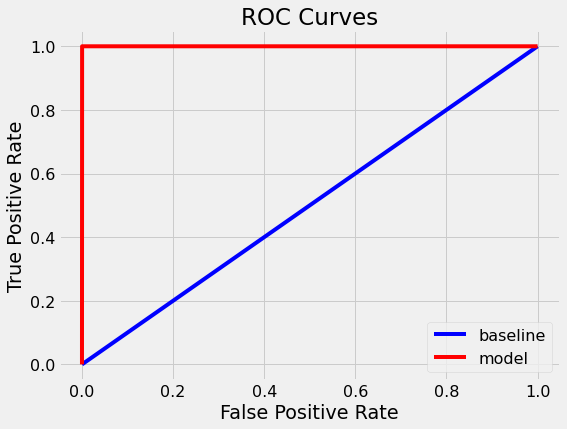

Normalized confusion matrix
[[9.99702157e-01 2.97842968e-04]
 [0.00000000e+00 1.00000000e+00]]


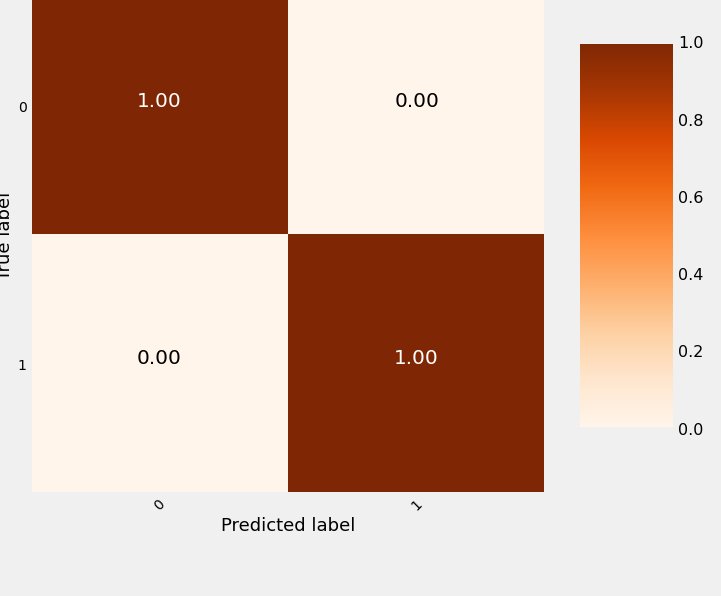

In [15]:
from utils.plotter import evaluate_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')



# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18


evaluate_model(rf_predictions, rf_probs, y_test,  train_rf_predictions, train_rf_probs, y_train)

from utils.plotter import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


# Confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix', normalize=True)